In [1]:
import smps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import os
import itertools

import matplotlib as mpl

In [2]:
# Initialize an empty DataFrame
df_lcs = pd.DataFrame()

# Define the start and end months and years
start_month = 3
start_year = 2024
end_month = 7
end_year = 2024

# Function to generate month-year strings
def generate_month_year_strings(start_month, start_year, end_month, end_year):
    month_year_list = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        month_year_list.append(f"{year}_{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return month_year_list

# Generate the list of month-year strings
month_year_strings = generate_month_year_strings(start_month, start_year, end_month, end_year)

# Loop through each month-year string and load the CSV files
for month_year_string in month_year_strings:
    year, month = month_year_string.split('_')
    filename_tail = f"@devnode_{year}-{month}.csv"
    directory = os.path.join("lcs_data", month_year_string)

    df_co = pd.read_csv(os.path.join(directory, f"raw_CO-B4{filename_tail}"), sep=',')
    df_smps_opcn3 = pd.read_csv(os.path.join(directory, f"raw_OPC-N3{filename_tail}"), sep=',')
    df_pm_opcn3 = pd.read_csv(os.path.join(directory, f"raw_PM-OPCN3{filename_tail}"), sep=',')
    df_pm_sps30 = pd.read_csv(os.path.join(directory, f"raw_PM-SPS30{filename_tail}"), sep=',')
    df_trh = pd.read_csv(os.path.join(directory, f"raw_T_RH_P_BME280{filename_tail}"), sep=',')
 
    # Combining all datasets using the "Čas" column
    df_temp = pd.merge(df_co, df_trh, on="Čas")
    df_temp = pd.merge(df_temp, df_smps_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_sps30, on="Čas")
    
    # Calculating actual values for the WE (working electrode) and AE (auxiliary electrode) values
    df_temp["CO"] = df_temp["WE_CO"] - df_temp["AE_CO"]
      
    # Dropping the extra columns (including the pressure - that makes a negligible difference)
    df_temp = df_temp.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)
    
    # Renaming the "Čas" column
    df_temp = df_temp.rename(columns={'Čas': 'Time'})
    
    # Converting the time to a datetime
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    
    # 1h shift of the CSV data (CSV seems to be UTC+1, reference data UTC)
    df_temp['Time'] += pd.Timedelta(hours=1)
    
    # Set 'Time' column as the DataFrame index
    df_temp.set_index('Time', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean for each group
    df_temp_1h = df_temp.resample('1h').mean()
    
    # Assign the calculated hourly means back to the original DataFrame
    df_temp = df_temp_1h.reset_index()
    
    # Append the data to the main DataFrame
    df_lcs = pd.concat([df_lcs, df_temp], ignore_index=True)

# Renaming the "Time" column to "GMT"
df_lcs = df_lcs.rename(columns={'Time': 'GMT'})

# Set 'GMT' column as the DataFrame index
df_lcs.set_index('GMT', inplace=True)

# Print the data types of the final DataFrame
print(df_lcs.dtypes)

T          float64
RH         float64
p          float64
bin0       float64
bin1       float64
bin2       float64
bin3       float64
bin4       float64
bin5       float64
bin6       float64
bin7       float64
bin8       float64
bin9       float64
bin10      float64
bin11      float64
bin12      float64
bin13      float64
bin14      float64
bin15      float64
bin16      float64
bin17      float64
bin18      float64
bin19      float64
bin20      float64
bin21      float64
bin22      float64
bin23      float64
PM_1_x     float64
PM_2.5     float64
PM_10_x    float64
PM_1_y     float64
PM_2       float64
PM_10_y    float64
CO         float64
dtype: object


In [3]:
# The edited dataset has the "Celkem" values at the end of the data removed
#df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")
df_ref = pd.DataFrame()

#df_ref = pd.read_csv('gmt_data/Nov-Feb_GMT_MarHory.csv', sep=';')
df_ref = pd.read_csv('gmt_data/Mar-Jul_GMT_MarHory.csv', sep=';')

#df_ref = df_ref.rename(columns={
#        'Unnamed: 0': 'Time',
#        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
#        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
#        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
#        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
#        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
#        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
#        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
#        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
#        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
#})

#Apply the function to the entire column
df_ref['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_ref['GMT'] = df_ref['GMT'].dt.tz_localize('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_ref = df_ref.drop(["TIME"], axis=1)

# Pokud potřebujete změnit pouze určité sloupce, můžete specifikovat sloupce takto:

df_ref[['WDIR [deg]', 
        'HUMI [%]', 
        'PRES [hPa]', 
        'TEMP [°C]', 
        'PM10 [ug/m3]', 
        'PM25 [ug/m3]', 
        'PM01 [ug/m3]', 
        'O3 [ug/m3]', 
        'SO2 [ug/m3]', 
        'NO [ug/m3]', 
        'NO2 [ug/m3]', 
        'CO [ug/m3]']] = df_ref[['WDIR [deg]', 
                                 'HUMI [%]', 
                                 'PRES [hPa]', 
                                 'TEMP [°C]', 
                                 'PM10 [ug/m3]', 
                                 'PM25 [ug/m3]', 
                                 'PM01 [ug/m3]', 
                                 'O3 [ug/m3]', 
                                 'SO2 [ug/m3]', 
                                 'NO [ug/m3]', 
                                 'NO2 [ug/m3]', 
                                 'CO [ug/m3]']].astype('float64')

#df_ref.head()
#print(df_ref.describe())
print(df_ref.dtypes)

GMT             datetime64[ns, UTC]
WSPE [m/s]                  float64
WDIR [deg]                  float64
HUMI [%]                    float64
PRES [hPa]                  float64
TEMP [°C]                   float64
PM10 [ug/m3]                float64
PM25 [ug/m3]                float64
PM01 [ug/m3]                float64
O3 [ug/m3]                  float64
SO2 [ug/m3]                 float64
NO [ug/m3]                  float64
NO2 [ug/m3]                 float64
CO [ug/m3]                  float64
dtype: object


In [4]:
df_cams = pd.DataFrame()

#df_cams = pd.read_csv('gmt_data/Nov-Feb_gmt_CAMS-EUR.csv', sep=';')
df_cams = pd.read_csv('gmt_data/Mar-Jul_gmt_CAMS-EUR.csv', sep=';')

df_cams['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_cams['GMT'] = df_cams['GMT'].dt.tz_convert('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_cams = df_cams.drop(["gmt"], axis=1)

#df_ref.head()
#print(df_ref.describe())
print(df_cams.dtypes)

pm10 (μg/m³)                            float64
pm2_5 (μg/m³)                           float64
carbon_monoxide (μg/m³)                 float64
nitrogen_dioxide (μg/m³)                float64
sulphur_dioxide (μg/m³)                 float64
ozone (μg/m³)                           float64
dust (μg/m³)                            float64
uv_index ()                             float64
ammonia (μg/m³)                         float64
GMT                         datetime64[ns, UTC]
dtype: object


In [5]:
# Merge the two DataFrames on the 'Time' column
df = pd.merge(df_lcs, df_ref, on='GMT')
df = pd.merge(df, df_cams, on='GMT')
# Sorting the values by the "Time" attribute
df.sort_values(by="GMT")
# Check the correlation between 'CO' and 'CO [µg/m3]'
#correlation = df_merged['CO'].diff().corr(df_merged['CO [ug/m3]'].diff())
#print(f'Correlation between CO and CO [µg/m3]: {correlation}')

#df.head()
print(df.describe())
#print(df.dtypes)

                 T           RH            p         bin0         bin1  \
count  2227.000000  2227.000000  2227.000000  2230.000000  2230.000000   
mean     17.703140    72.408413   985.139575   717.754776   138.219855   
std       6.998633    21.050424     5.076952   727.405015   305.311701   
min      -1.186194    29.580972   964.608333    21.124837     2.510131   
25%      13.295458    53.668181   982.000000   180.647608    13.402083   
50%      17.911639    72.820444   985.055556   422.453563    28.697222   
75%      22.433536    93.179875   989.000000  1040.795139    92.040972   
max      38.385283   100.000000   996.000000  3621.586111  2473.836111   

              bin2         bin3         bin4         bin5         bin6  ...  \
count  2230.000000  2230.000000  2230.000000  2230.000000  2230.000000  ...   
mean     42.424502     9.304688    10.193214     6.851119     4.350572  ...   
std     127.587379    34.671482    40.350403    29.465975    22.506491  ...   
min       0.67500

In [6]:
start_date = '2023-11-01'
end_date = '2024-07-08'

# Filter the DataFrame
sel_df = df[df['GMT'] >= start_date]
sel_df = sel_df[sel_df['GMT'] <= end_date]

# Sorting the values by the "GMT" attribute
df = sel_df.sort_values(by="GMT")

df["T"] = pd.to_numeric(df["T"], errors='coerce') + 273.15
df["CO"] = pd.to_numeric(df["CO"], errors='coerce') * 4394 + (-0.693)* pd.to_numeric(df["T"], errors='coerce')

#df.head()
print(df[['T',"CO",'HUMI [%]','PRES [hPa]']].describe())

                 T            CO     HUMI [%]   PRES [hPa]
count  1962.000000   1962.000000  3086.000000  3086.000000
mean    289.813290    178.197705    74.143876   976.983474
std       6.582443    437.111247    20.393266    44.745678
min     271.963806    -30.551128    27.000000   911.000000
25%     285.624004     79.507487    57.000000   926.000000
50%     290.198778    122.213046    76.000000  1005.000000
75%     294.515740    184.006733    95.000000  1016.000000
max     306.265306  14543.146767    99.000000  1035.000000


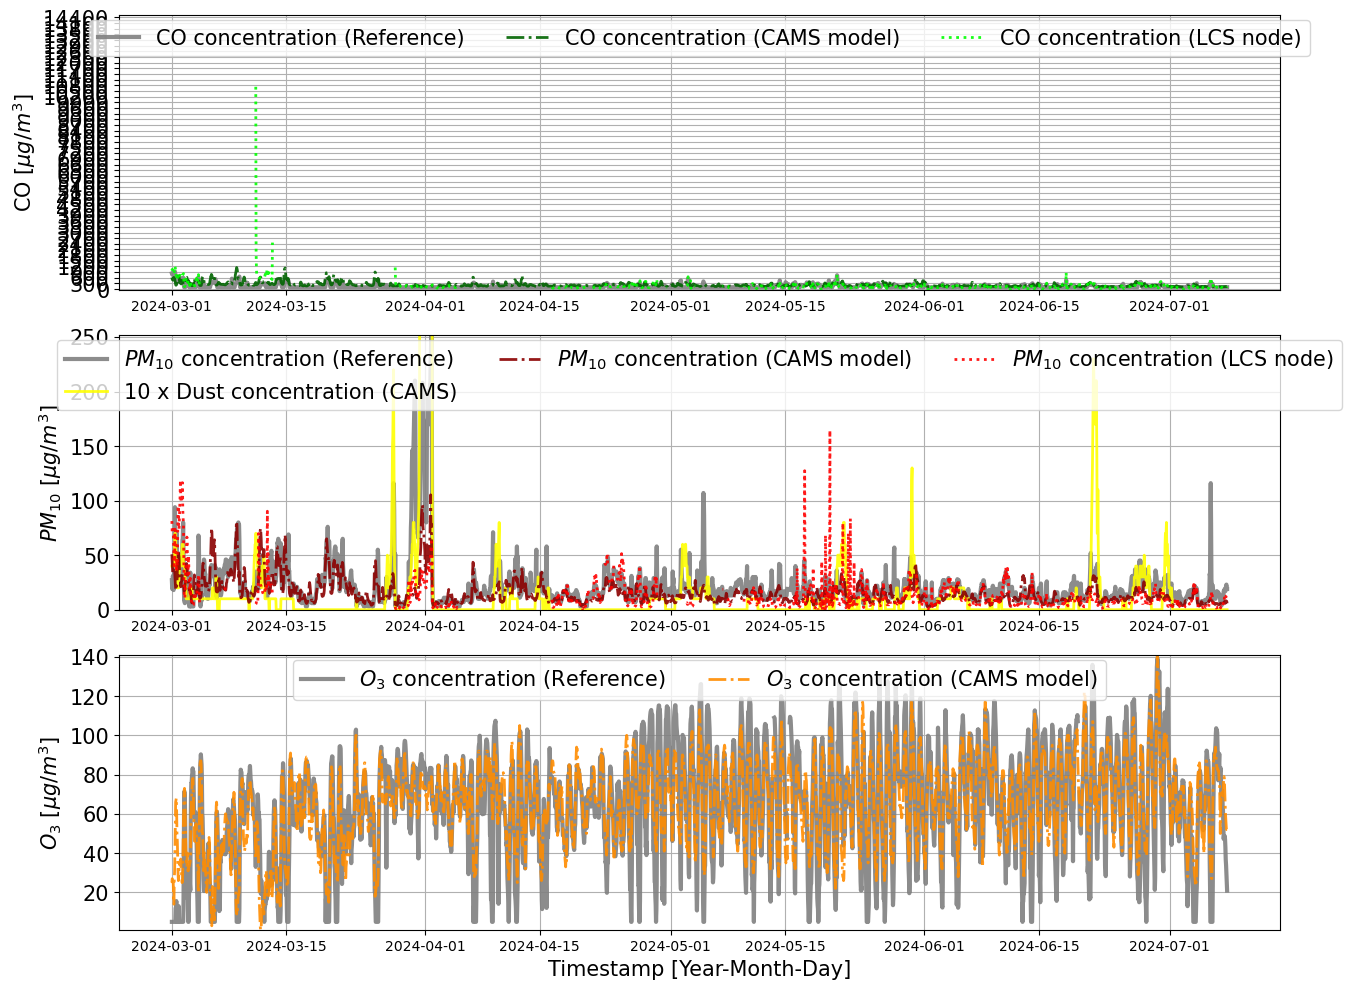

In [7]:
# Create a figure and a set of subplots with adjusted height
fig, axs = plt.subplots(3, 1, figsize=(14, 10))  # 4 rows, 1 column, reduced height

# Define the y-axis limits for CO
y_min = min(df['CO [ug/m3]'].min(), df['carbon_monoxide (μg/m³)'].min(), df['CO'].min())
y_max = max(df['CO [ug/m3]'].max(), df['carbon_monoxide (μg/m³)'].max(), df['CO'].max())

# First subplot
axs[0].plot(df['GMT'], df['CO [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='CO concentration (Reference)')
axs[0].plot(df['GMT'], df['carbon_monoxide (μg/m³)'], color="darkgreen", linestyle="dashdot", linewidth=2, alpha=0.9, label='CO concentration (CAMS model)')
axs[0].plot(df['GMT'], df['CO'], color="lime", linestyle="dotted", linewidth=2, alpha=0.9,  label='CO concentration (LCS node)')
axs[0].set_ylabel('CO [$µg/m^3$]', fontsize=15)
axs[0].grid(True)
axs[0].set_ylim(y_min, y_max)
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(300))  # Adjust interval as needed
axs[0].tick_params(axis='y', labelsize=15)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for PM10
y_min = min(df['PM10 [ug/m3]'].min(), df['pm10 (μg/m³)'].min(), df['PM_10_y'].min())
y_max = max(df['PM10 [ug/m3]'].max(), df['pm10 (μg/m³)'].max(), df['PM_10_y'].max())

# Second subplot
axs[1].plot(df['GMT'], df['PM10 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$PM_{10}$ concentration (Reference)')
axs[1].plot(df['GMT'], df['dust (μg/m³)']*10, color="yellow", linestyle="solid", linewidth=2, alpha=0.9, label='10 x Dust concentration (CAMS)')
axs[1].plot(df['GMT'], df['pm10 (μg/m³)'], color="darkred", linestyle="dashdot", linewidth=2, alpha=0.9, label='$PM_{10}$ concentration (CAMS model)')
axs[1].plot(df['GMT'], df['PM_10_y'], color="red", linestyle="dotted", linewidth=2, alpha=0.9,  label='$PM_{10}$ concentration (LCS node)')
axs[1].set_ylabel('$PM_{10}$ [$µg/m^3$]', fontsize=15)
axs[1].grid(True)
axs[1].set_ylim(y_min, y_max)
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(50))  # Adjust interval as needed
axs[1].tick_params(axis='y', labelsize=15)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for O3
y_min = min(df['O3 [ug/m3]'].min(), df['ozone (μg/m³)'].min())
y_max = max(df['O3 [ug/m3]'].max(), df['ozone (μg/m³)'].max())

# Fourth subplot
axs[2].plot(df['GMT'], df['O3 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$O_3$ concentration (Reference)')
axs[2].plot(df['GMT'], df['ozone (μg/m³)'], color="darkorange", linestyle="dashdot", linewidth=2, alpha=0.9, label='$O_3$ concentration (CAMS model)')
axs[2].set_ylabel('$O_3$ [$µg/m^3$]', fontsize=15)
axs[2].set_xlabel('Timestamp [Year-Month-Day]', fontsize=15)
axs[2].grid(True)
axs[2].set_ylim(y_min, y_max)
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(20))  # Adjust interval as needed
axs[2].tick_params(axis='y', labelsize=15)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.02 * y_max / y_max), ncol=3, fontsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
print("Columns in DataFrame (df):", df.columns)

Columns in DataFrame (df): Index(['GMT', 'T', 'RH', 'p', 'bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5',
       'bin6', 'bin7', 'bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13',
       'bin14', 'bin15', 'bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21',
       'bin22', 'bin23', 'PM_1_x', 'PM_2.5', 'PM_10_x', 'PM_1_y', 'PM_2',
       'PM_10_y', 'CO', 'WSPE [m/s]', 'WDIR [deg]', 'HUMI [%]', 'PRES [hPa]',
       'TEMP [°C]', 'PM10 [ug/m3]', 'PM25 [ug/m3]', 'PM01 [ug/m3]',
       'O3 [ug/m3]', 'SO2 [ug/m3]', 'NO [ug/m3]', 'NO2 [ug/m3]', 'CO [ug/m3]',
       'pm10 (μg/m³)', 'pm2_5 (μg/m³)', 'carbon_monoxide (μg/m³)',
       'nitrogen_dioxide (μg/m³)', 'sulphur_dioxide (μg/m³)', 'ozone (μg/m³)',
       'dust (μg/m³)', 'uv_index ()', 'ammonia (μg/m³)'],
      dtype='object')


In [9]:
df['GMT'] = pd.to_datetime(df['GMT'])

# Nastavte sloupec GMT jako index
df.set_index('GMT', inplace=True)

# Zkontrolujte, zda je index správně nastaven
print(df.head())

                                    T     RH           p         bin0  \
GMT                                                                     
2024-03-01 01:00:00+00:00  279.135100  100.0  985.000000  1770.193333   
2024-03-01 02:00:00+00:00  278.684528  100.0  984.566667  1753.683333   
2024-03-01 03:00:00+00:00  278.190167  100.0  983.961111  1766.427778   
2024-03-01 04:00:00+00:00  277.734528  100.0  983.177778  1743.358333   
2024-03-01 05:00:00+00:00  277.319389  100.0  983.080556  1968.163889   

                                  bin1        bin2        bin3        bin4  \
GMT                                                                          
2024-03-01 01:00:00+00:00  1471.040000  711.820000  191.096667  251.260000   
2024-03-01 02:00:00+00:00  1250.633333  541.133333  151.036111  223.566667   
2024-03-01 03:00:00+00:00  1321.125000  601.255556  170.688889  243.088889   
2024-03-01 04:00:00+00:00  1373.480556  726.536111  240.269444  351.591667   
2024-03-01 05:00:00+

In [10]:
# Load the data into a ModulairPM object
obj = smps.models.AlphasenseOPCN3(data=df)
obj.midpoints

array([ 0.405,  0.56 ,  0.83 ,  1.15 ,  1.5  ,  2.   ,  2.65 ,  3.5  ,
        4.6  ,  5.85 ,  7.25 ,  9.   , 11.   , 13.   , 15.   , 17.   ,
       19.   , 21.   , 23.5  , 26.5  , 29.5  , 32.5  , 35.5  , 38.5  ])

In [11]:
obj.dn.head(3)

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23
GMT,,,,,,,,,,,,,,,,,,,,,
2024-03-01 01:00:00+00:00,1770.193333,1471.040000,711.820000,191.096667,251.260000,260.553333,271.670000,91.880000,79.083333,45.446667,...,28.916667,28.913333,28.470000,27.136667,36.746667,29.080000,21.390000,14.006667,9.186667,15.500000
2024-03-01 02:00:00+00:00,1753.683333,1250.633333,541.133333,151.036111,223.566667,238.638889,244.027778,76.033333,75.586111,59.975000,...,45.600000,39.308333,34.841667,28.872222,32.586111,21.172222,13.347222,7.758333,4.511111,7.861111
2024-03-01 03:00:00+00:00,1766.427778,1321.125000,601.255556,170.688889,243.088889,249.927778,243.550000,68.316667,57.177778,43.072222,...,35.805556,31.611111,28.269444,24.769444,29.052778,21.000000,14.600000,9.247222,6.300000,10.791667


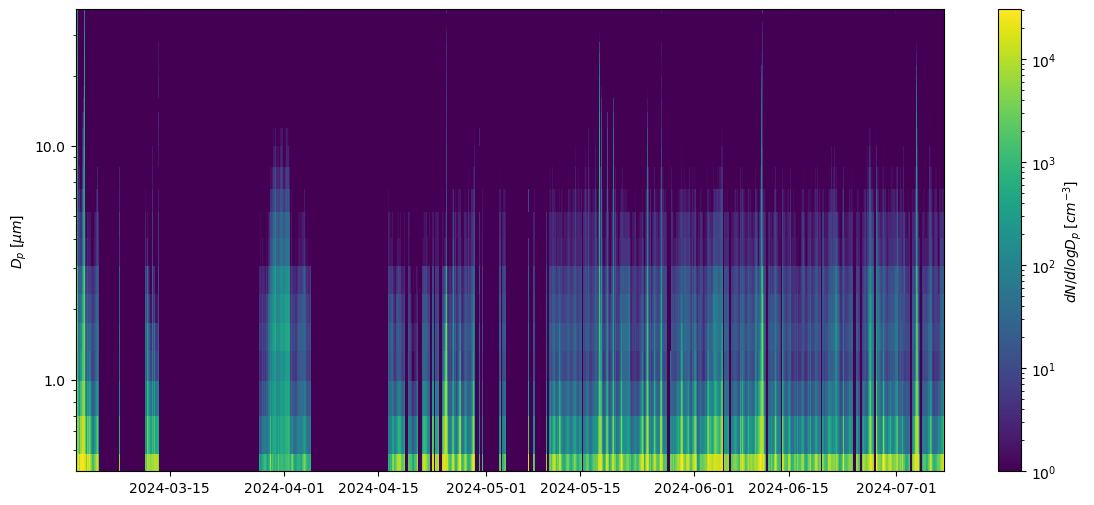

In [12]:
X = obj.dndlogdp.index
Y = obj.midpoints
Z = obj.dndlogdp.T.values

# Plot the data
ax = smps.plots.heatmap(
    X, Y, Z,
    cmap='viridis',
    fig_kws=dict(figsize=(14, 6))
)

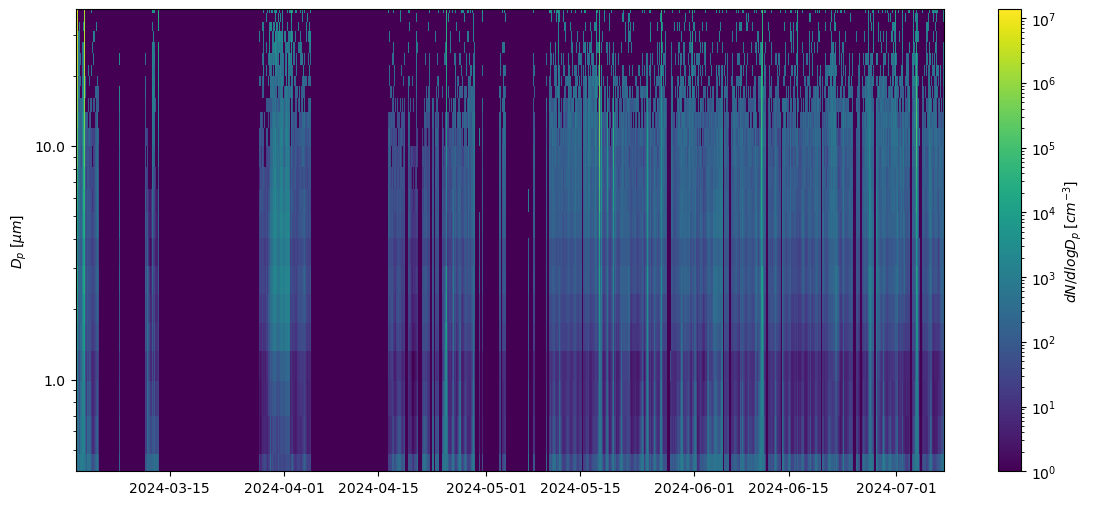

In [13]:
X = obj.dvdlogdp.index
Y = obj.midpoints
Z = obj.dvdlogdp.T.values

# Plot the data
ax = smps.plots.heatmap(
    X, Y, Z,
    cmap='viridis',
    fig_kws=dict(figsize=(14, 6))
)

In [14]:
# Vytvořte seznam unikátních dat ve formátu datetime64[ns]
dates = df.index.unique()

# Ujistěte se, že index je typu DatetimeIndex
obj.dvdlogdp.index = pd.to_datetime(obj.dvdlogdp.index)
print(obj.dvdlogdp.index)

DatetimeIndex(['2024-03-01 01:00:00+00:00', '2024-03-01 02:00:00+00:00',
               '2024-03-01 03:00:00+00:00', '2024-03-01 04:00:00+00:00',
               '2024-03-01 05:00:00+00:00', '2024-03-01 06:00:00+00:00',
               '2024-03-01 07:00:00+00:00', '2024-03-01 08:00:00+00:00',
               '2024-03-01 09:00:00+00:00', '2024-03-01 10:00:00+00:00',
               ...
               '2024-07-07 15:00:00+00:00', '2024-07-07 16:00:00+00:00',
               '2024-07-07 17:00:00+00:00', '2024-07-07 18:00:00+00:00',
               '2024-07-07 19:00:00+00:00', '2024-07-07 20:00:00+00:00',
               '2024-07-07 21:00:00+00:00', '2024-07-07 22:00:00+00:00',
               '2024-07-07 23:00:00+00:00', '2024-07-08 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='GMT', length=3096, freq=None)


In [15]:
# Převzorkujte data na 24hodinové průměry
df_resampled = df.resample('D').mean()

# Vytvořte seznam unikátních dat ve formátu datetime64[ns]
dates = df_resampled.index.unique()
print(dates)

DatetimeIndex(['2024-03-01 00:00:00+00:00', '2024-03-02 00:00:00+00:00',
               '2024-03-03 00:00:00+00:00', '2024-03-04 00:00:00+00:00',
               '2024-03-05 00:00:00+00:00', '2024-03-06 00:00:00+00:00',
               '2024-03-07 00:00:00+00:00', '2024-03-08 00:00:00+00:00',
               '2024-03-09 00:00:00+00:00', '2024-03-10 00:00:00+00:00',
               ...
               '2024-06-29 00:00:00+00:00', '2024-06-30 00:00:00+00:00',
               '2024-07-01 00:00:00+00:00', '2024-07-02 00:00:00+00:00',
               '2024-07-03 00:00:00+00:00', '2024-07-04 00:00:00+00:00',
               '2024-07-05 00:00:00+00:00', '2024-07-06 00:00:00+00:00',
               '2024-07-07 00:00:00+00:00', '2024-07-08 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='GMT', length=130, freq='D')


In [16]:
objd = smps.models.AlphasenseOPCN3(data=df_resampled)
objd.dn.head(3)

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23
GMT,,,,,,,,,,,,,,,,,,,,,
2024-03-01 00:00:00+00:00,2281.893932,1031.100680,355.254000,84.119234,100.709409,87.304223,73.873909,19.560604,16.977657,11.921613,...,8.600864,7.947560,7.301353,6.461516,7.992748,5.843092,4.086884,2.652947,1.713430,3.119203
2024-03-02 00:00:00+00:00,2213.816503,1045.085083,384.884477,98.482571,116.716517,93.882993,82.299639,28.735607,31.117572,24.078874,...,6.884252,5.544601,4.901062,4.278030,4.984511,3.056250,1.634491,0.736458,0.313657,0.254398
2024-03-03 00:00:00+00:00,797.895164,146.718894,28.146325,3.595855,2.686067,1.290881,0.605632,0.202071,0.147046,0.050447,...,0.001852,0.000463,0.000463,0.000694,0.000463,0.000579,0.000579,0.000116,0.000000,0.000231


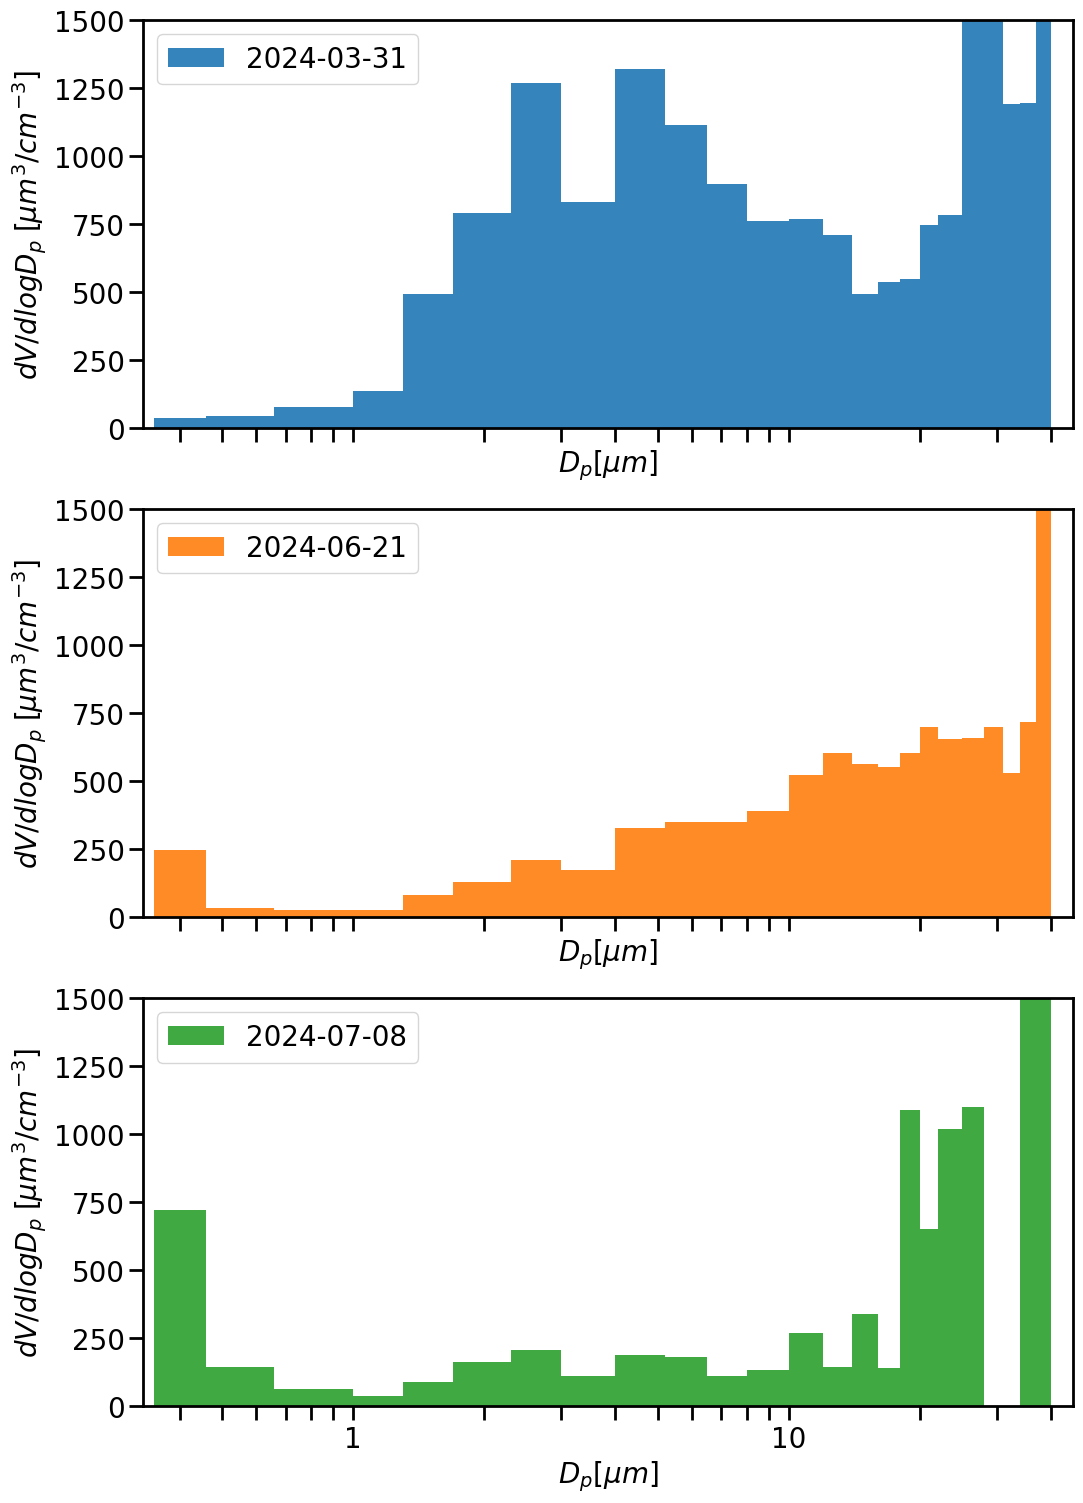

In [17]:
# Vyberte tři konkrétní data
selected_dates = ["2024-03-31", "2024-06-21", "2024-07-08"]
selected_dates = pd.to_datetime(selected_dates)

# Inicializujte proměnné pro graf
cp = itertools.cycle(sns.color_palette())

# Vytvořte subgrafy
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12, 18))

# Ujistěte se, že index je typu DatetimeIndex
objd.dvdlogdp.index = pd.to_datetime(objd.dvdlogdp.index)

# Vytvořte graf pro každé vybrané datum
for ax, date in zip(axs, selected_dates):
    filtered_data = objd.dvdlogdp.loc[objd.dvdlogdp.index.date == date.date()]
    smps.plots.histplot(
        filtered_data,
        objd.bins,
        ax=ax,
        plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
    )
    ax.set_xlim(0.33, 45)  # Nastavení rozsahu osy y
    ax.set_ylim(0, 1500)  # Nastavení rozsahu osy y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Formátování osy y
    ax.set_ylabel("$dV/dlogD_p \; [µm^3/cm^{-3}]$", fontsize=20)  # Zvýšení velikosti písma
    ax.set_xlabel("$D_p [µm]$", fontsize=20)  # Zvýšení velikosti písma
    ax.legend([date.strftime('%Y-%m-%d')], loc='upper left', fontsize=20)  # Zvýšení velikosti písma legendy
    ax.tick_params(axis='both', which='major', labelsize=20)  # Zvýšení velikosti popisků os
    ax.tick_params(axis='x', which='both', length=10, width=2)  # Zvýraznění x-ticks
    ax.tick_params(axis='y', which='both', length=10, width=2)  # Zvýraznění y-ticks

# Nastavení popisku osy x pro poslední subgraf
axs[-1].set_xlabel("$D_p$[$\mu m$]", fontsize=20)  # Zvýšení velikosti písma

# Odstranění horní a pravé osy a zvýšení tloušťky obrysů
# sns.despine()
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Zvýšení tloušťky obrysů

# Zobrazení grafu
plt.show()


In [18]:
# Převzorkujte data na 24hodinové průměry
df_resampled = df.resample('ME').median()

# Vytvořte seznam unikátních dat ve formátu datetime64[ns]
dates = df_resampled.index.unique()
print(dates)

DatetimeIndex(['2024-03-31 00:00:00+00:00', '2024-04-30 00:00:00+00:00',
               '2024-05-31 00:00:00+00:00', '2024-06-30 00:00:00+00:00',
               '2024-07-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='GMT', freq='ME')


In [19]:
objm = smps.models.AlphasenseOPCN3(data=df_resampled)
objm.dn.head(3)

,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin14,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23
GMT,,,,,,,,,,,,,,,,,,,,,
2024-03-31 00:00:00+00:00,554.852999,76.081944,28.480556,5.356944,5.276389,2.872222,1.315278,0.381944,0.254167,0.088889,...,0.002778,0.002778,0.002778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-30 00:00:00+00:00,267.961111,25.113889,7.186111,1.630556,1.805556,1.205556,0.605556,0.205556,0.153758,0.063889,...,0.002778,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-31 00:00:00+00:00,352.933333,28.073333,7.080556,1.475855,2.011111,1.458333,0.963889,0.391667,0.313889,0.138889,...,0.005556,0.002778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pm1=objm.integrate(weight='mass', dmin=0., dmax=1., rho=1.65)
pm10=objm.integrate(weight='mass', dmin=0., dmax=10., rho=1.65)
print(pm1)
print(pm10)

GMT
2024-03-31 00:00:00+00:00    57.456171
2024-04-30 00:00:00+00:00    22.738861
2024-05-31 00:00:00+00:00    28.012413
2024-06-30 00:00:00+00:00    40.060952
2024-07-31 00:00:00+00:00    23.013022
Freq: ME, dtype: float64
GMT
2024-03-31 00:00:00+00:00    200.476072
2024-04-30 00:00:00+00:00    100.364847
2024-05-31 00:00:00+00:00    172.758962
2024-06-30 00:00:00+00:00    190.776196
2024-07-31 00:00:00+00:00    176.518010
Freq: ME, dtype: float64


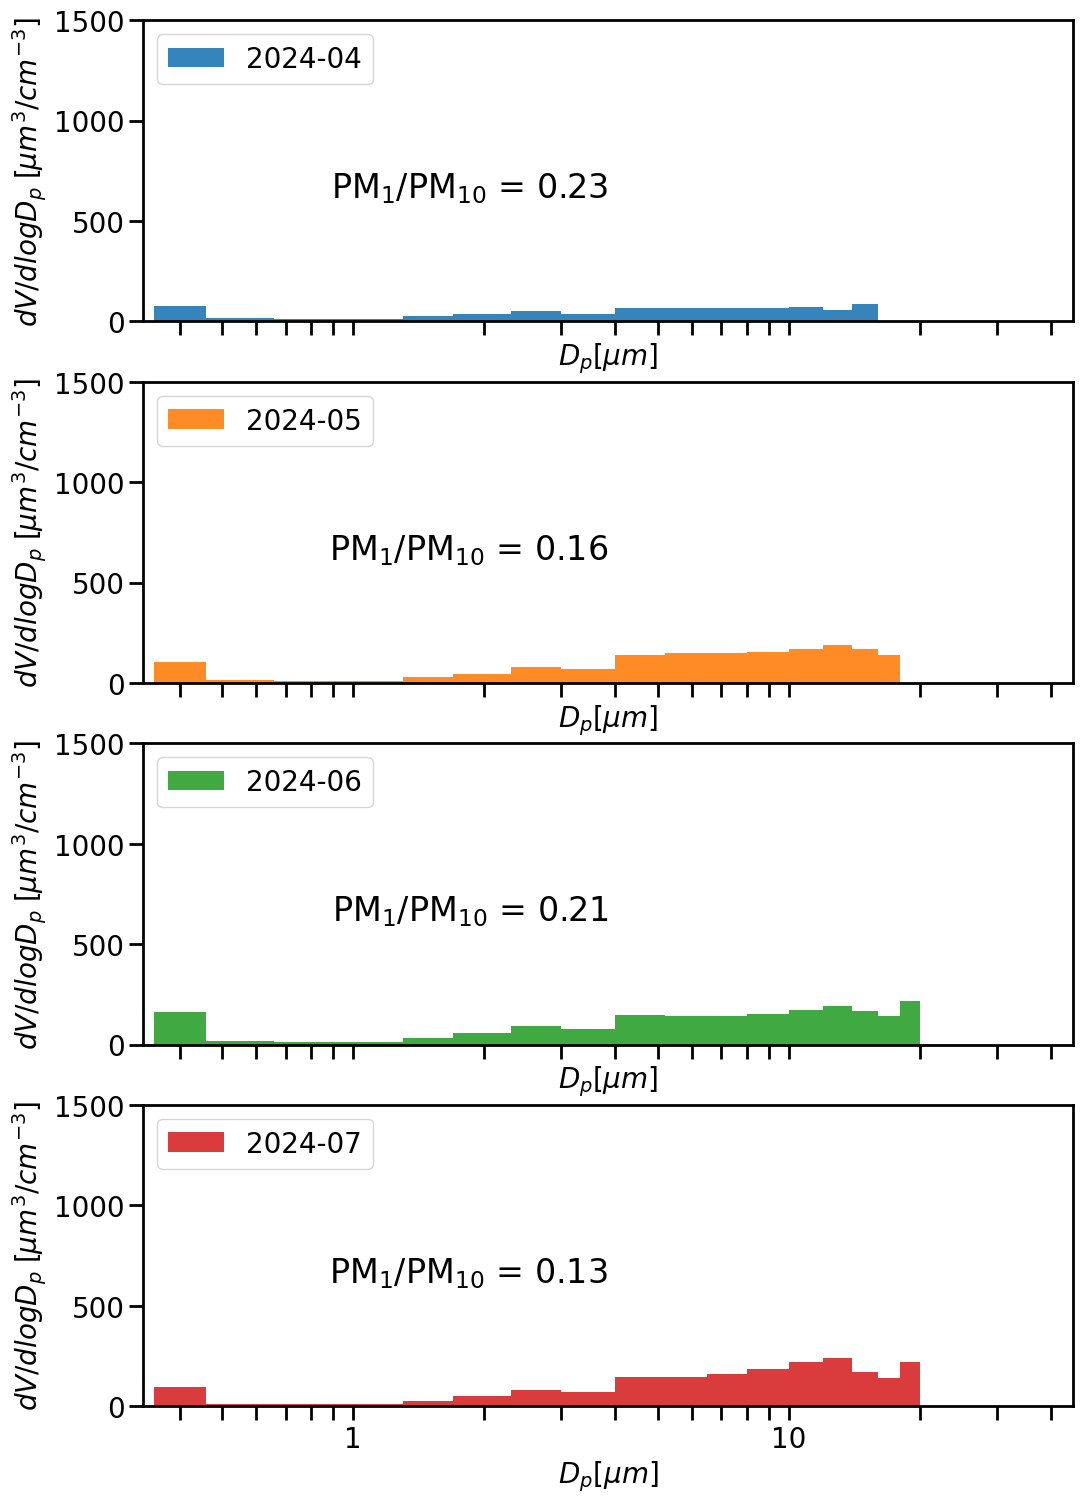

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Example DataFrame with PM1 and PM10 values
data = {
    'date': ["2024-04-30","2024-05-31", "2024-06-30", "2024-07-31"],
    'pm1': [22.738861, 28.012413, 40.060952, 23.013022],
    'pm10': [100.364847, 172.758962, 190.776196, 176.518010]
}
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Selected dates
selected_dates = ["2024-04-30","2024-05-31", "2024-06-30", "2024-07-31"]
selected_dates = pd.to_datetime(selected_dates)

# Initialize variables for the plot
cp = itertools.cycle(sns.color_palette())

# Create subplots
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 18))

# Ensure the index is of type DatetimeIndex
objm.dvdlogdp.index = pd.to_datetime(objm.dvdlogdp.index)

# Create a plot for each selected date
for ax, date in zip(axs, selected_dates):
    filtered_data = objm.dvdlogdp.loc[objm.dvdlogdp.index.date == date.date()]
    smps.plots.histplot(
        filtered_data,
        objm.bins,
        ax=ax,
        plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
    )
    ax.set_xlim(0.33, 45)  # Set x-axis range
    ax.set_ylim(0, 1500)  # Set y-axis range
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Format y-axis
    ax.set_ylabel("$dV/dlogD_p \; [µm^3/cm^{-3}]$", fontsize=20)  # Increase font size
    ax.set_xlabel("$D_p [µm]$", fontsize=20)  # Increase font size
    ax.legend([date.strftime('%Y-%m')], loc='upper left', fontsize=20)  # Increase legend font size
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
    ax.tick_params(axis='x', which='both', length=10, width=2)  # Highlight x-ticks
    ax.tick_params(axis='y', which='both', length=10, width=2)  # Highlight y-ticks

    # Calculate PM1/PM10 ratio and add text box
    pm1_value = df.loc[date, 'pm1']
    pm10_value = df.loc[date, 'pm10']
    ratio = pm1_value / pm10_value
    ax.text(0.5, 0.5, f'PM$_1$/PM$_{{10}}$ = {ratio:.2f}', transform=ax.transAxes, fontsize=24,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.0))

# Set x-axis label for the last subplot
axs[-1].set_xlabel("$D_p$[$\mu m$]", fontsize=20)  # Increase font size

# Remove top and right spines and increase border thickness
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Increase border thickness

# Show the plot
plt.show()

In [24]:
pm1ref=df_resampled['PM01 [ug/m3]']
pm10ref=df_resampled['PM10 [ug/m3]']
print(pm1ref/pm10ref)

GMT
2024-03-31 00:00:00+00:00    0.521739
2024-04-30 00:00:00+00:00    0.466667
2024-05-31 00:00:00+00:00    0.424242
2024-06-30 00:00:00+00:00    0.466667
2024-07-31 00:00:00+00:00    0.333333
Freq: ME, dtype: float64


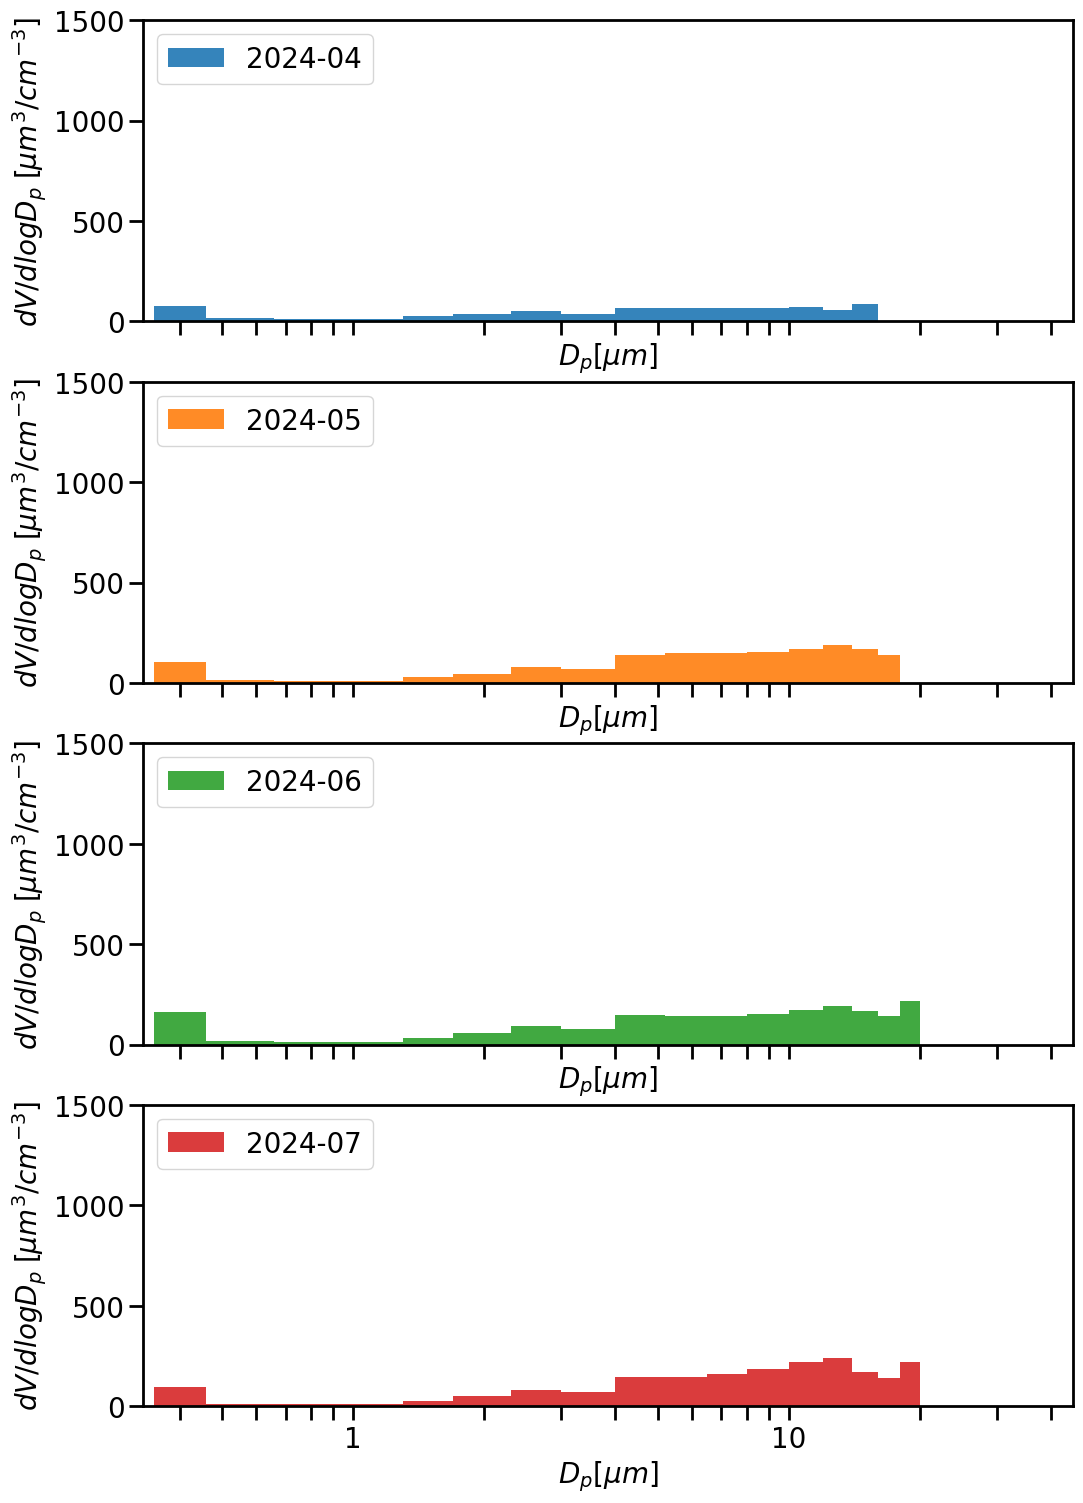

In [22]:
# Vyberte tři konkrétní data
selected_dates = ["2024-04-30","2024-05-31", "2024-06-30", "2024-07-31"]
selected_dates = pd.to_datetime(selected_dates)

# Inicializujte proměnné pro graf
cp = itertools.cycle(sns.color_palette())

# Vytvořte subgrafy
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12, 18))

# Ujistěte se, že index je typu DatetimeIndex
objm.dvdlogdp.index = pd.to_datetime(objm.dvdlogdp.index)

# Vytvořte graf pro každé vybrané datum
for ax, date in zip(axs, selected_dates):
    filtered_data = objm.dvdlogdp.loc[objm.dvdlogdp.index.date == date.date()]
    smps.plots.histplot(
        filtered_data,
        objm.bins,
        ax=ax,
        plot_kws=dict(alpha=0.9, color=next(cp), linewidth=0.9)
    )
    ax.set_xlim(0.33, 45)  # Nastavení rozsahu osy y
    ax.set_ylim(0, 1500)  # Nastavení rozsahu osy y
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))  # Formátování osy y
    ax.set_ylabel("$dV/dlogD_p \; [µm^3/cm^{-3}]$", fontsize=20)  # Zvýšení velikosti písma
    ax.set_xlabel("$D_p [µm]$", fontsize=20)  # Zvýšení velikosti písma
    ax.legend([date.strftime('%Y-%m')], loc='upper left', fontsize=20)  # Zvýšení velikosti písma legendy
    ax.tick_params(axis='both', which='major', labelsize=20)  # Zvýšení velikosti popisků os
    ax.tick_params(axis='x', which='both', length=10, width=2)  # Zvýraznění x-ticks
    ax.tick_params(axis='y', which='both', length=10, width=2)  # Zvýraznění y-ticks

# Nastavení popisku osy x pro poslední subgraf
axs[-1].set_xlabel("$D_p$[$\mu m$]", fontsize=20)  # Zvýšení velikosti písma

# Odstranění horní a pravé osy a zvýšení tloušťky obrysů
# sns.despine()
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Zvýšení tloušťky obrysů

# Zobrazení grafu
plt.show()

In [23]:
# Přejmenování sloupců
df.rename(columns={
    'PM_1_y': 'LCS node $PM_1$',
    'PM_2': 'LCS node $PM_{2.5}$',
    'PM_10_opcn3': 'LCS node $PM_{10}$',
    'CO': 'LCS node CO',
    'PM10 [ug/m3]': 'Reference $PM_{10}$',
    'PM25 [ug/m3]': 'Reference $PM_{2.5}$',
    'PM01 [ug/m3]': 'Reference $PM_1$',
    'O3 [ug/m3]': 'Reference $O_3$',
    'NO2 [ug/m3]': 'Reference $NO_2$',
    'CO [ug/m3]': 'Reference CO',
    'pm10 (μg/m³)': 'CAMS model $PM_{10}$',
    'pm2_5 (μg/m³)': 'CAMS model $PM_{2.5}$',
    'carbon_monoxide (μg/m³)': 'CAMS model CO',
    'nitrogen_dioxide (μg/m³)': 'CAMS model $NO_2$',
    'ozone (μg/m³)': 'CAMS model $O_3$'}, inplace=True)

# Zobrazení přejmenovaných sloupců
print(df.columns)

Index(['pm1', 'pm10'], dtype='object')
